<AxesSubplot: >

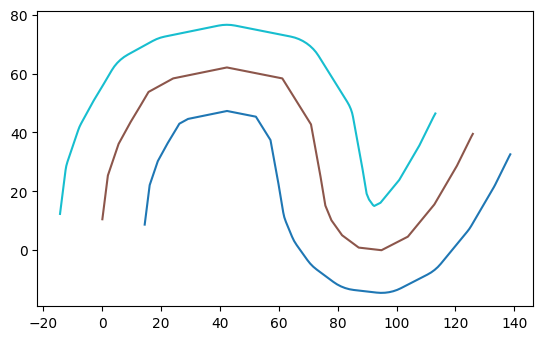

In [1]:
import pickle, os
import sys
import skimage as ski
sys.path.insert(0, "/home/adriano/projeto_mestrado/modules/")

import geopandas as gpd
import background_generation as backgen

root_dir ="/home/adriano/projeto_mestrado/modules"

img_dir = root_dir + '/Imagens/vessel_data/images'
#Varrendo o diretório
# filenames = []
# for filename in os.listdir(img_dir):    
#   filenames.append(filename.split('.')[0])
# filenames = filenames[:20]

imag = 'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 2-20X'

#Lendo o pickle e gerando o vessel_map
idx = 1
pickle_dir = f'{root_dir}/Vessel_Models_pickle'
path = (pickle_dir + f'/{imag}_savedata1.pickle')
arquivo = pickle.load(open(path, 'rb'))
vessel_map = arquivo['vessel_model'].vessel_map
mapa_original = vessel_map.mapped_values

rows, cols = mapa_original.shape[0], mapa_original.shape[1]
distancia = (rows/2)

#Lendo o Json
#arquivo = f'{root_dir}/Artificial_Lines/arquivo_quatro_pontos.json'
#arquivo = f'{root_dir}/Artificial_Lines/arquivo_quatro_pontos.json'
arquivo = f'{root_dir}/Artificial_Lines/teste_31_05.json'
#arquivo = f'{root_dir}/Artificial_Lines/teste2_31_05.json'
#arquivo = f'{root_dir}/Artificial_Lines/teste.json'

medial_path = backgen.retorna_paths(arquivo)
caminhos_transladados_interpolado = backgen.retorna_caminhos_transladados(medial_path[0], 2)

linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho = backgen.retorna_linhas_offset_posicao_tamanho(caminhos_transladados_interpolado[0],distancia)

gp4 = gpd.GeoSeries([linha_offset_esquerda, linha_central, linha_offset_direita])
gp4.plot(cmap="tab10")


### Plotando os pontos

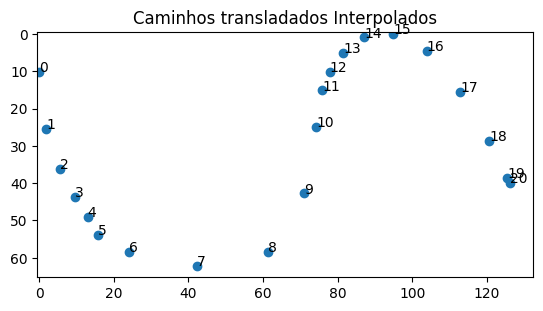

In [2]:
pontos_x = caminhos_transladados_interpolado[0][:,0]
pontos_y = caminhos_transladados_interpolado[0][:,1]
backgen.plotar_pontos(pontos_x, pontos_y, 'Caminhos transladados Interpolados' )

### Exibição do mapa normal


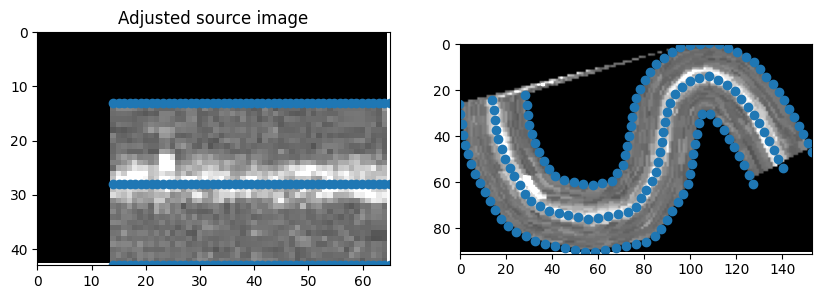

In [3]:
import numpy as np

mapa = np.array(mapa_original)

rows, cols = mapa.shape[0], mapa.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

dst_array_np = backgen.retorna_dst_array_np(linha_central,linha_offset_esquerda,linha_offset_direita, maior_tamanho)

img_proper, img_out, new_src, new_dst, tform = backgen.transform_v2(src, dst_array_np, mapa)
backgen.plot(img_proper, img_out, new_src, new_dst, 60)

### Lendo o pickle e gerando o vessel_map e a imagem binária sem artefatos

[]

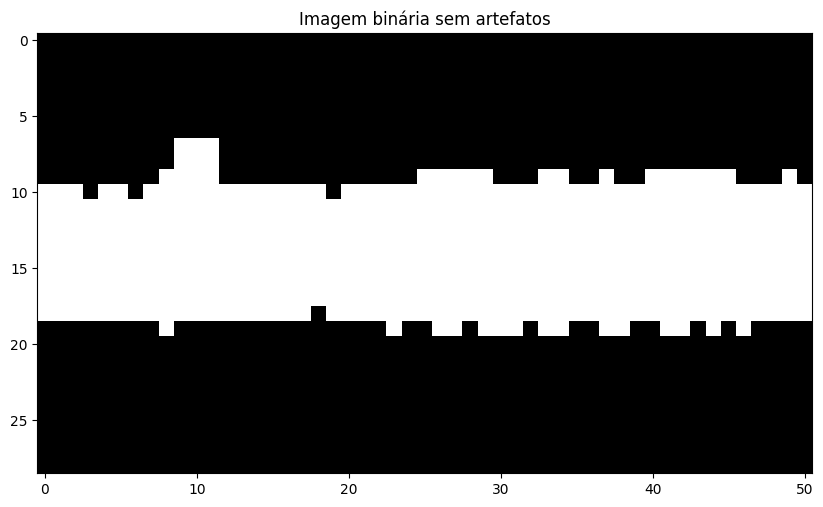

In [4]:
#import cv2
from PIL import Image
import matplotlib.pyplot as plt

img = np.array(Image.open(img_dir + f'/{imag}.tiff'))

path = (pickle_dir + f'/{imag}_savedata1.pickle')

arquivo = pickle.load(open(path, 'rb'))

vessel_map = arquivo['vessel_model'].vessel_map

mapa_original = vessel_map.mapped_values

#cv2.imwrite('mapa_original.png', mapa_original)

imagem_binaria_original = vessel_map.mapped_mask_values

imagem_binaria_sem_artefatos_laterais = backgen.retornar_imagem_binaria_sem_artefatos(vessel_map, imagem_binaria_original)


imagem_binaria_sem_artefatos = backgen.fill_holes(imagem_binaria_sem_artefatos_laterais)


plt.figure(figsize=[10, 8])
plt.title("Imagem binária sem artefatos")
plt.imshow(imagem_binaria_sem_artefatos, 'gray', vmin=0, vmax=1)
plt.plot()

### Expandir mapas

In [5]:
maior_valor_interpolado = np.max(caminhos_transladados_interpolado[0])
mapa_expandido_original = backgen.expandir_mapas_do_tamanho_do_tracado(mapa_original,maior_valor_interpolado)
mapa_expandido_bin = backgen.expandir_mapas_do_tamanho_do_tracado(imagem_binaria_sem_artefatos,maior_valor_interpolado)
mask_mapa_expandido_bin = np.ones(mapa_expandido_bin.shape)

### Exibindo o Mapa Aumentado

[]

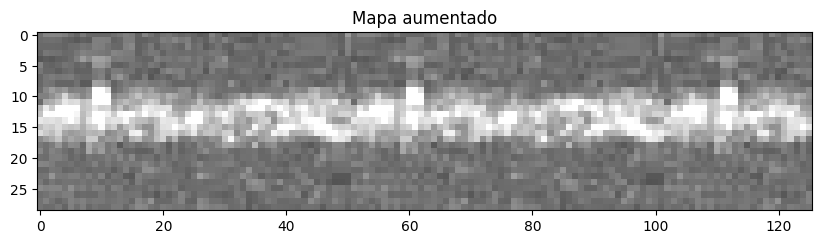

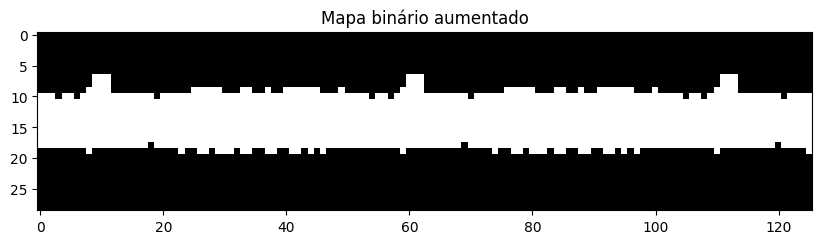

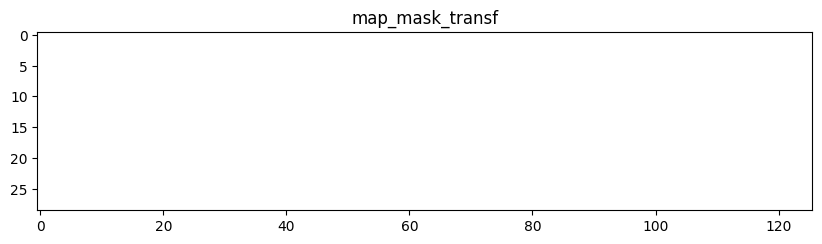

In [6]:
plt.figure(figsize=[10, 8])
plt.title("Mapa aumentado")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("Mapa binário aumentado")
plt.imshow(mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()
plt.figure(figsize=[10, 8])
plt.title("map_mask_transf")
plt.imshow(mask_mapa_expandido_bin, 'gray', vmin=0, vmax=1)
plt.plot()

### Execução do Algoritmo com o Mapa Expandido

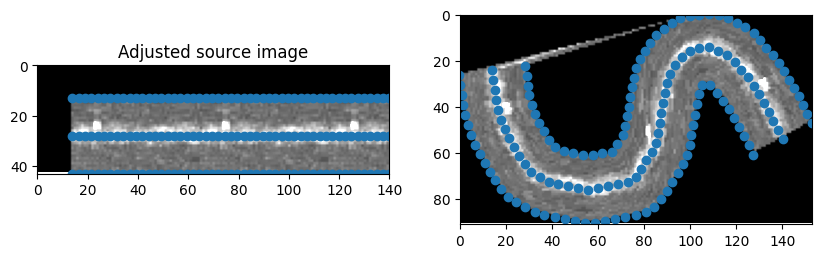

In [7]:
rows, cols = mapa_expandido_original.shape[0], mapa_expandido_original.shape[1]

src_cols = np.linspace(0, cols, maior_tamanho)
src_rows = np.linspace(-1, rows, 3)
src_cols, src_rows = np.meshgrid(src_cols,src_rows)
src = np.dstack([src_cols.flat, src_rows.flat])[0]


img_proper, img_out, new_src, new_dst, tform_out = backgen.transform_v2(src, dst_array_np, mapa_expandido_original)
backgen.plot(img_proper, img_out, new_src, new_dst,vmax=60)

### Criação da mask binária do mapa

In [8]:
tam = len(new_dst)

div = tam//3

vetor_div =[div,div*2,div*3]

parte_direita = new_dst[0:vetor_div[0]]
parte_centro = new_dst[vetor_div[0]:vetor_div[1]]
parte_esquerda = new_dst[vetor_div[1]:vetor_div[2]]

lista_somada = np.concatenate((parte_esquerda, parte_direita[::-1]))
polygon = np.array(lista_somada)[:,::-1]
mask_map = ski.draw.polygon2mask(img_out.shape, polygon)
mask_map.astype(int)
mask_map_sq = mask_map.squeeze()
#mask_inv = mask[::-1]

# plt.imshow(mask, 'gray')
# mask_pil = Image.fromarray(mask.astype(np.uint8))
# mask_pil.save("imagem.tiff")

### Criação da máscara do vaso

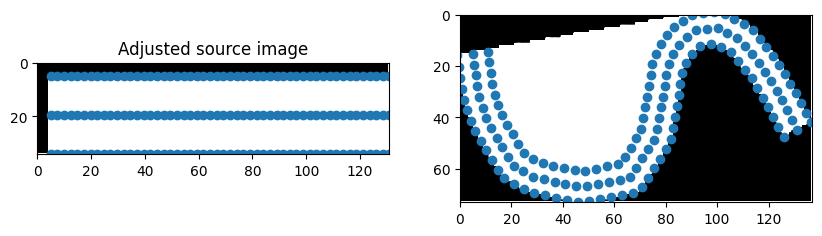

In [18]:
linha_minima = int(np.min(np.rint(vessel_map.path2_mapped)))
linha_maxima  = int(np.max(np.rint(vessel_map.path1_mapped)))

diametro_maximo_vaso = (linha_maxima-linha_minima)/2

linha_mask_central,linha_mask_esquerda,linha_mask_direita, max_tam = backgen.retorna_linhas_offset_posicao_tamanho(caminhos_transladados_interpolado[0],diametro_maximo_vaso)

dst_mask_np = backgen.retorna_dst_array_np(linha_mask_central,linha_mask_esquerda,linha_mask_direita, max_tam)

rows_bin, cols_bin = mapa_expandido_original.shape[0], mapa_expandido_original.shape[1]

src_cols_bin = np.linspace(0, cols_bin, max_tam)
src_rows_bin = np.linspace(0, rows_bin, 3)
src_cols_bin, src_rows_bin = np.meshgrid(src_cols_bin,src_rows_bin)
src_bin = np.dstack([src_cols_bin.flat, src_rows_bin.flat])[0]

img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, tform_out_bin = backgen.transform_v2(src_bin, dst_mask_np, mapa_expandido_original)


backgen.plot(img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, vmax=1)

tam = len(new_dst_bin)

div = tam//3

vetor_div =[div,div*2,div*3]

parte_direita = new_dst_bin[0:vetor_div[0]]
parte_centro = new_dst_bin[vetor_div[0]:vetor_div[1]] 
parte_esquerda = new_dst_bin[vetor_div[1]:vetor_div[2]] 

lista_somada = np.concatenate((parte_esquerda, parte_direita[::-1]))
polygon = np.array(lista_somada)[:,::-1]
mask_vessel = ski.draw.polygon2mask(img_out.shape, polygon) # type: ignore
mask_vessel.astype(int)
mask_vessel_sq = mask_vessel.squeeze()

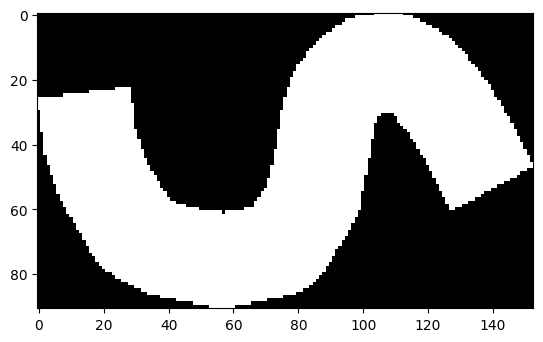

In [26]:
plt.imshow(mask_vessel_sq, 'gray')

plt.imshow(mask_vessel_sq, 'gray')



### Execução do Algoritmo com o Mapa Expandido - Binário

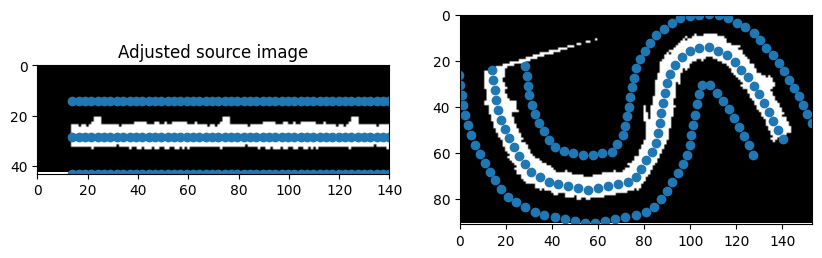

In [ ]:
rows_bin, cols_bin = mapa_expandido_bin.shape[0], mapa_expandido_bin.shape[1]

src_cols_bin = np.linspace(0, cols_bin, maior_tamanho)
src_rows_bin = np.linspace(0, rows_bin, 3)
src_cols_bin, src_rows_bin = np.meshgrid(src_cols_bin,src_rows_bin)
src_bin = np.dstack([src_cols_bin.flat, src_rows_bin.flat])[0]


img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, tform_out_bin = backgen.transform_v2(src_bin, dst_array_np, mapa_expandido_bin)
backgen.plot(img_proper_bin, img_out_bin, new_src_bin, new_dst_bin, vmax=1)

### Plotando os pontos alterados e aumentados

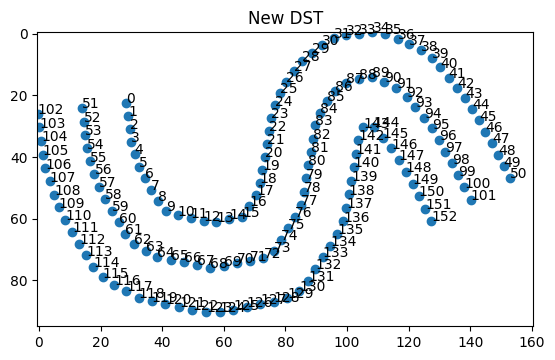

In [ ]:
pontos_x = new_dst[:,0]
pontos_y = new_dst[:,1]
backgen.plotar_pontos(pontos_x, pontos_y, 'New DST')

### Exibindo o mapa original e os modificados

[]

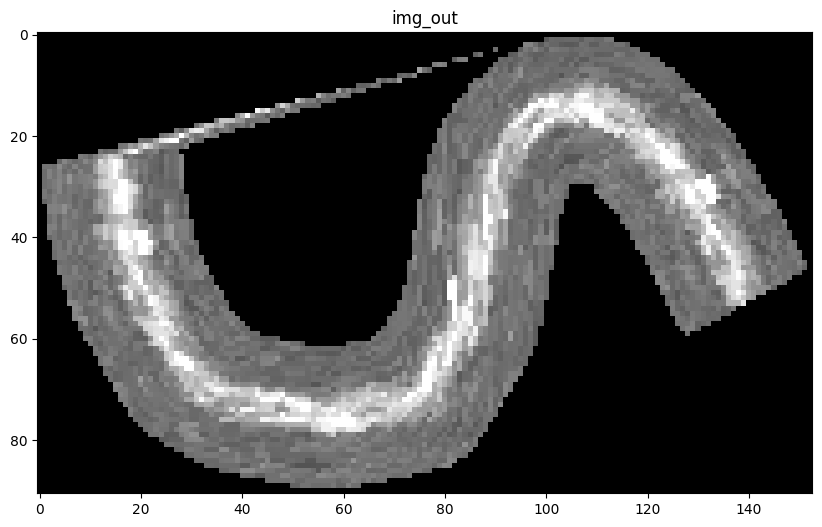

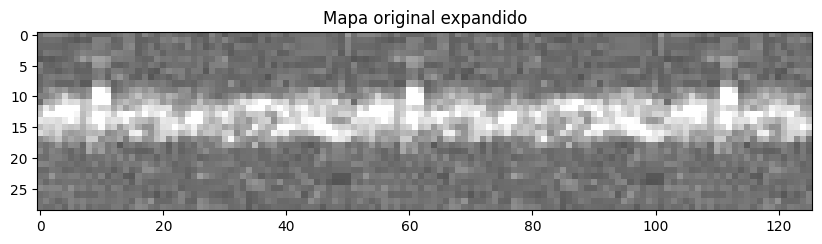

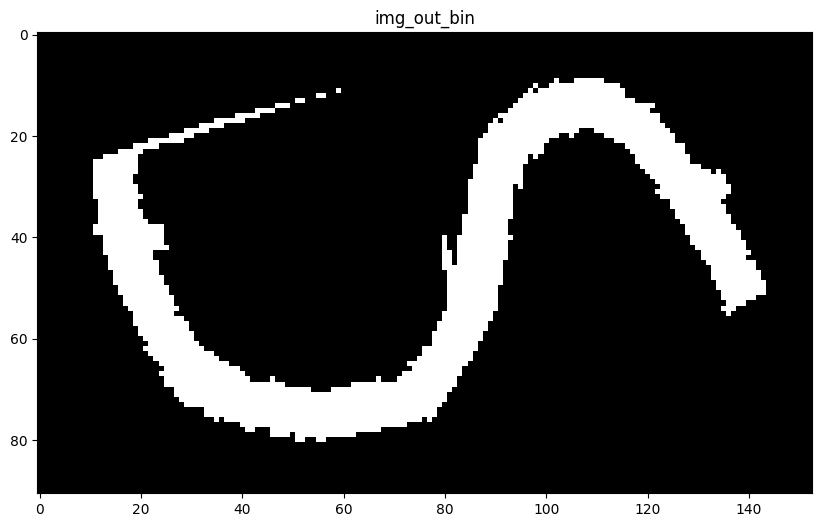

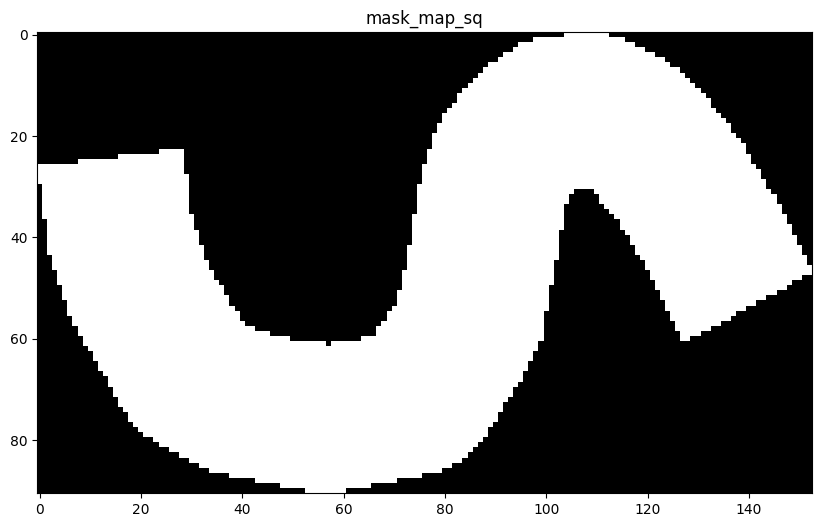

In [ ]:
plt.figure(figsize=[10, 8])
plt.title("img_out")
plt.imshow(img_out, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("Mapa original expandido")
plt.imshow(mapa_expandido_original, 'gray', vmin=0, vmax=60)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("img_out_bin")
plt.imshow(img_out_bin, 'gray', vmin=0, vmax=1)
plt.plot()

plt.figure(figsize=[10, 8])
plt.title("mask_map_sq")
plt.imshow(mask_map_sq, 'gray', vmin=0, vmax=1)
plt.plot()

### Retirar chifres

[]

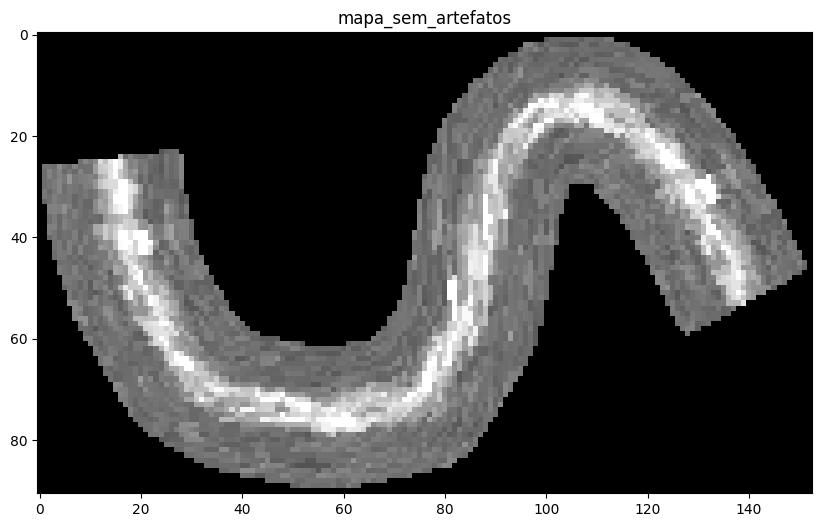

In [ ]:
img_out_sq = img_out.squeeze()

mapa_sem_artefatos = np.zeros(img_out_sq.shape)

for i in range(mapa_sem_artefatos.shape[0]):
    for j in range(mapa_sem_artefatos.shape[1]):
        if mask_map_sq[i, j] == True:  # Verifica se o pixel é branco na imagem booleana
            # Inserindo o pixel quando a máscara tem True
            mapa_sem_artefatos[i, j] = img_out_sq[i,j]

plt.figure(figsize=[10, 8])
plt.title("mapa_sem_artefatos")
plt.imshow(mapa_sem_artefatos, 'gray', vmin=0, vmax=60)
plt.plot()


In [ ]:
mapa_sem_artefatos.shape

(91, 153)

In [ ]:
print(mask_vessel_sq.shape)

(91, 153)


[]

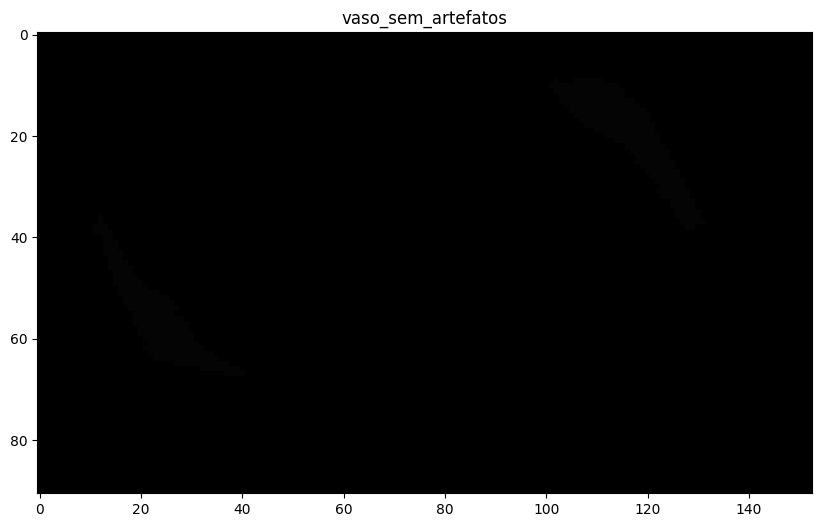

In [ ]:
img_out_bin_sq = img_out_bin.squeeze()

vaso_sem_artefatos = np.zeros(img_out_bin_sq.shape)

for i in range(vaso_sem_artefatos.shape[0]):
    for j in range(vaso_sem_artefatos.shape[1]):
        if mask_vessel_sq[i, j] == True:  # Verifica se o pixel é branco na imagem booleana
            # Inserindo o pixel quando a máscara tem True
            vaso_sem_artefatos[i, j] = img_out_bin_sq[i,j]

plt.figure(figsize=[10, 8])
plt.title("vaso_sem_artefatos")
plt.imshow(vaso_sem_artefatos, 'gray', vmin=0, vmax=60)
plt.plot()

### Inserindo o mapa em um background criado artificialmente

[]

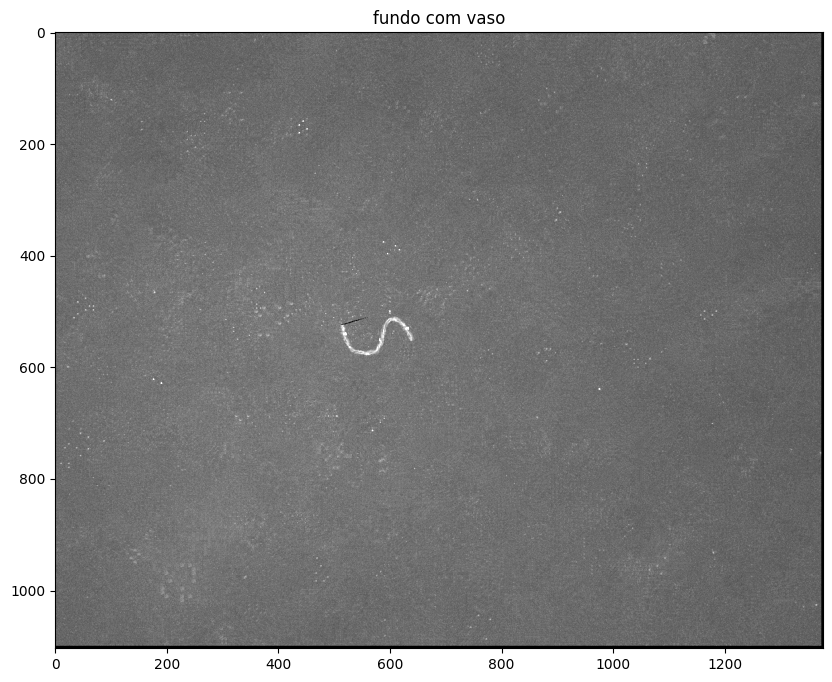

In [ ]:

back_artif = np.array(Image.open(root_dir + f'/Background/Mapas_gerados_artificialmente/{imag}.tiff'))

img_out_sq = img_out.squeeze()
#img_out_transf_sq = img_out_transf_bin.squeeze()

#Mergear
#fundo = backgen.estimate_background(img, label)

# img_out_sq = mapa transformado
# img_out_bin_sq = vaso binário transformado
# img_out_transf_bin_sq = mapa binário transformado

img_out_bin_sq = img_out_bin.squeeze()

point = (500,500)
limiar = 30
background = back_artif
img_merged = backgen.inserindo_vaso_fundo2(mapa_sem_artefatos,img_out_bin_sq,background,point,limiar)

plt.figure(figsize=[10, 8])
plt.title("fundo com vaso")
plt.imshow(img_merged, 'gray', vmin=0, vmax=60)
plt.plot()

### Exibindo os triângulos de Delaunay

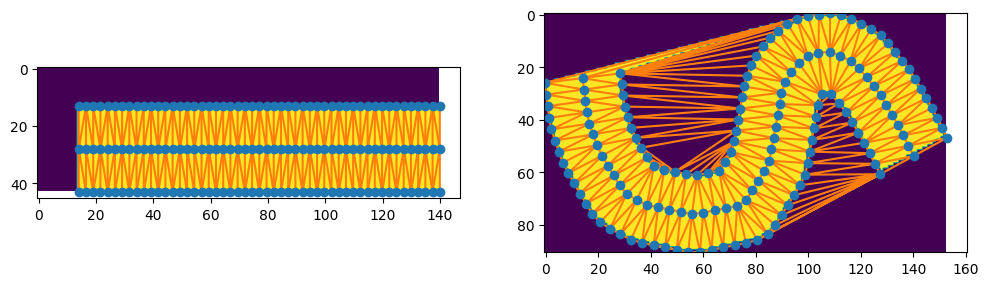

In [ ]:
from skimage.transform import PiecewiseAffineTransform, warp
#img_proper_transf_bin, img_out_transf_bin, new_src_transf_bin, new_dst_transf_bin, tform_transf_bin

tri = tform_transf_bin._tesselation 
tri_inv = tform_transf_bin._inverse_tesselation 
backgen.delaunay_plot(img_proper_transf_bin, img_out_transf_bin, tri, tri_inv)